In [1]:
cd .. 

c:\Users\shish\Purdue\First Sem\Independent Study\Final_Proj_SM\Github_Proj\SoMoBoost


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import shap
import rasterio
from rasterio.plot import show

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


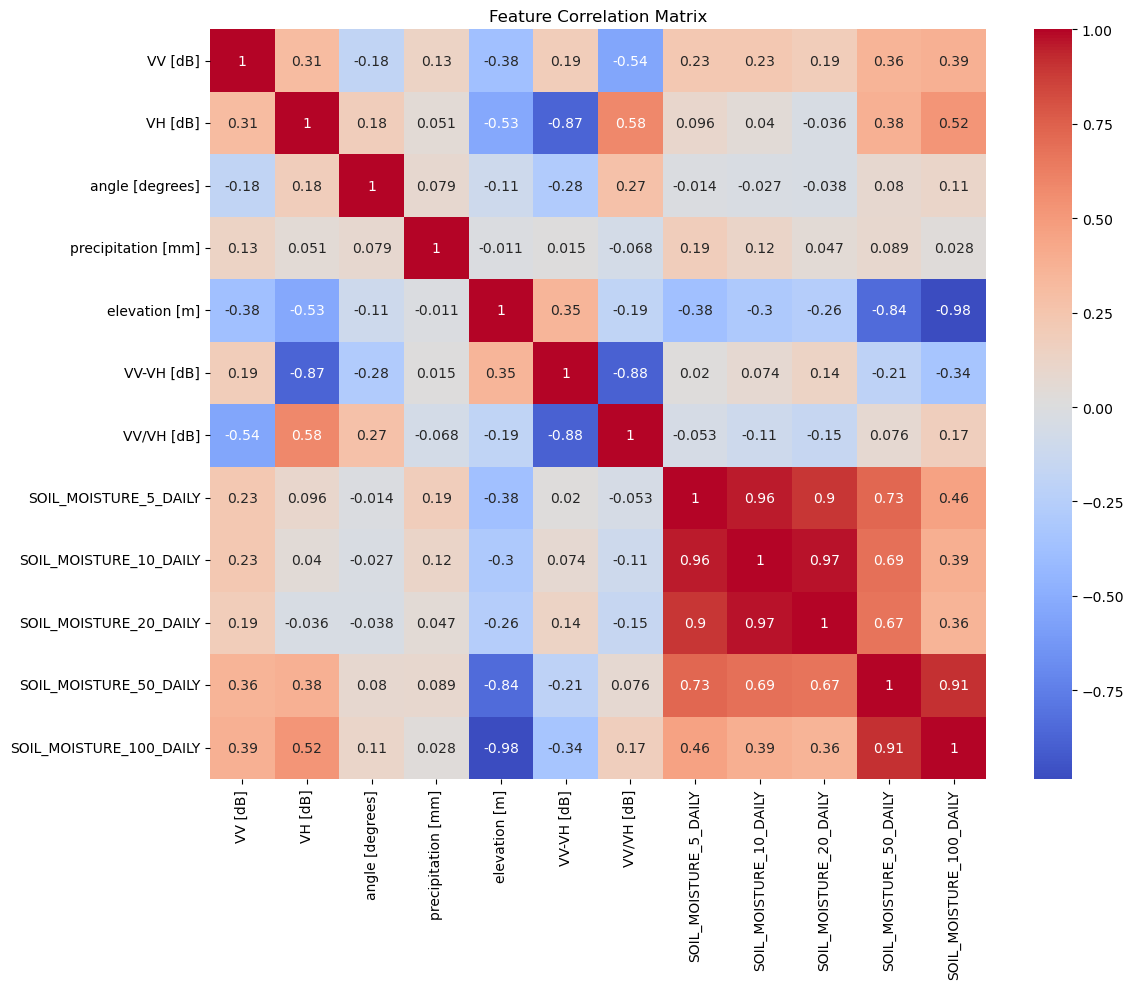

In [3]:
# Load and preprocess data
df = pd.read_csv("Datasets/ML_Training_Selected.csv")

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")

# Save the figure before showing
plt.tight_layout()
plt.savefig("Results/correlation_matrix.png", dpi=300)
plt.show()


In [4]:
# Calculate SOIL_MOISTURE_15_DAILY and SOIL_MOISTURE_75_DAILY
#df['SOIL_MOISTURE_15_DAILY'] = (df['SOIL_MOISTURE_10_DAILY'] + df['SOIL_MOISTURE_20_DAILY']) / 2
#df['SOIL_MOISTURE_75_DAILY'] = (df['SOIL_MOISTURE_50_DAILY'] + df['SOIL_MOISTURE_100_DAILY']) / 2

# Drop unnecessary columns
#df.drop(columns=['SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'], inplace=True)

# Clean column names
df.columns = df.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')

# Define features
features = ['VV_dB', 'VH_dB', 'angle_degrees', 'precipitation_mm', 'elevation_m', 'VV-VH_dB', 'VV/VH_dB']

# Normalize elevation
scaler = StandardScaler()
df['elevation_m'] = scaler.fit_transform(df[['elevation_m']])

# Target variables
targets = {
    'SOIL_MOISTURE_5_DAILY': None,
    'SOIL_MOISTURE_10_DAILY': None,
    'SOIL_MOISTURE_20_DAILY': None,
    'SOIL_MOISTURE_50_DAILY': None,
    'SOIL_MOISTURE_100_DAILY': None,
}


--- Training SVR for SOIL_MOISTURE_5_DAILY ---
100%|██████████| 50/50 [00:00<00:00, 150.16trial/s, best loss: 0.07696166351453623]
Train R²: 0.251, KGE: 0.249, NSE: 0.251
Test R²: 0.240, KGE: 0.182, NSE: 0.240


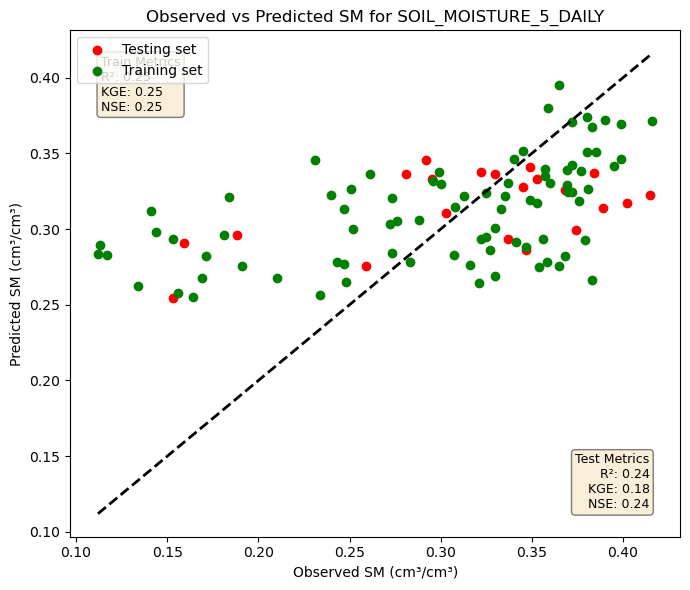

100%|██████████| 84/84 [00:04<00:00, 19.70it/s]


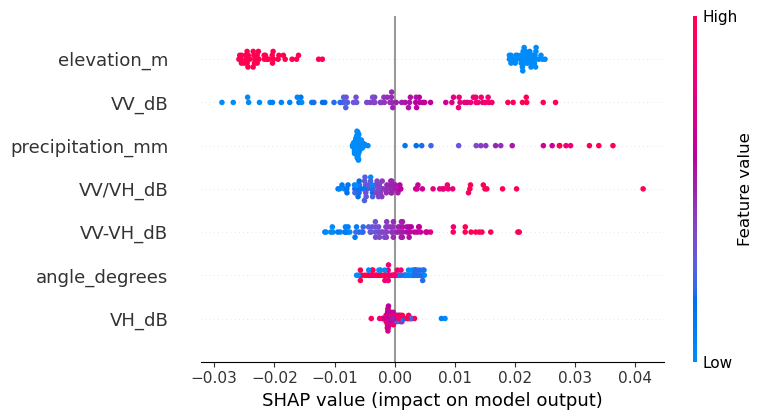


--- Training SVR for SOIL_MOISTURE_10_DAILY ---
100%|██████████| 50/50 [00:00<00:00, 137.95trial/s, best loss: 0.06753645438383377]
Train R²: 0.269, KGE: 0.220, NSE: 0.269
Test R²: 0.109, KGE: 0.109, NSE: 0.109


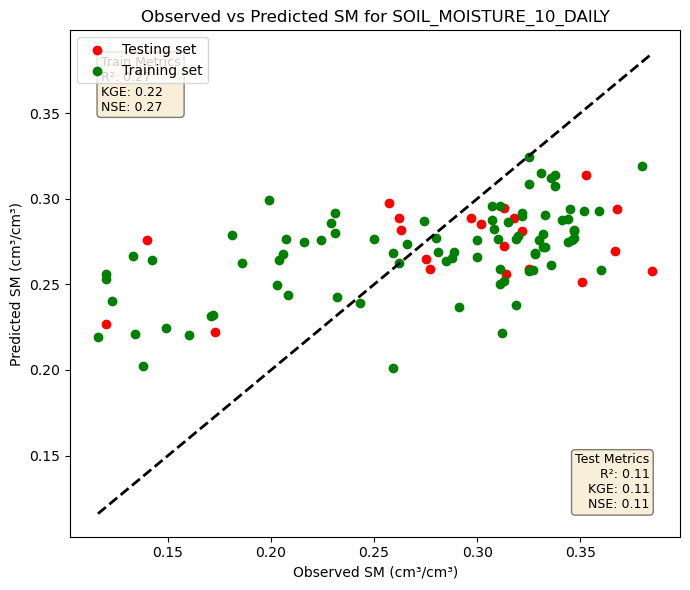

100%|██████████| 84/84 [00:03<00:00, 25.24it/s]


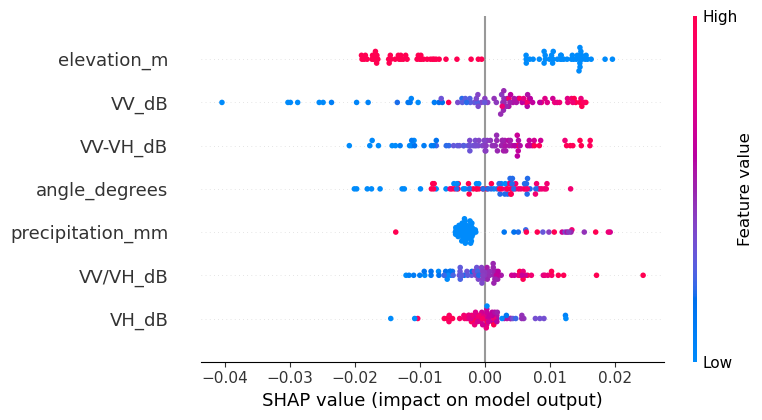


--- Training SVR for SOIL_MOISTURE_20_DAILY ---
100%|██████████| 50/50 [00:00<00:00, 143.70trial/s, best loss: 0.05416371305541297]
Train R²: 0.351, KGE: 0.364, NSE: 0.351
Test R²: 0.085, KGE: 0.366, NSE: 0.085


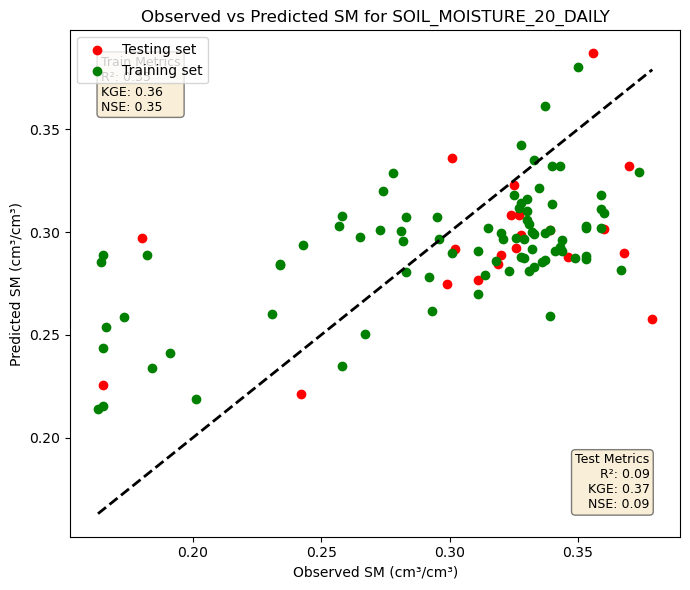

100%|██████████| 84/84 [00:03<00:00, 27.65it/s]


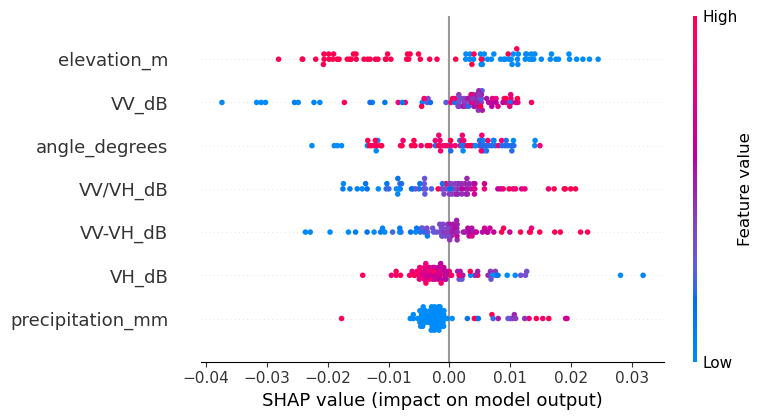


--- Training SVR for SOIL_MOISTURE_50_DAILY ---
100%|██████████| 50/50 [00:00<00:00, 130.53trial/s, best loss: 0.049351219632424385]
Train R²: 0.734, KGE: 0.710, NSE: 0.734
Test R²: 0.543, KGE: 0.694, NSE: 0.543


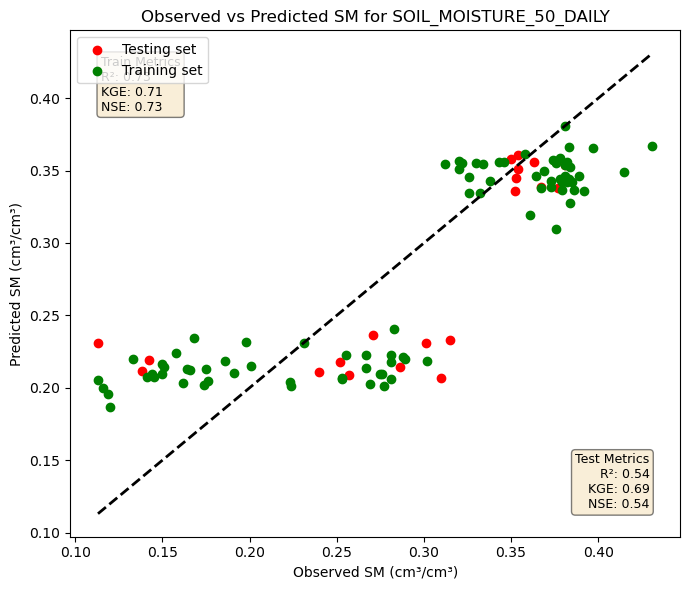

100%|██████████| 84/84 [00:02<00:00, 31.18it/s]


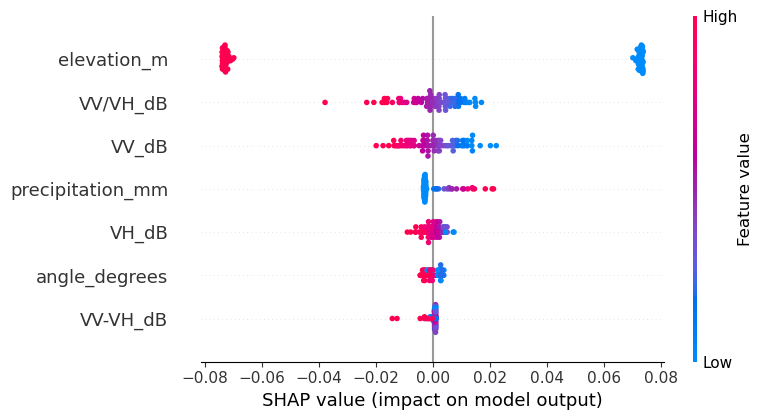


--- Training SVR for SOIL_MOISTURE_100_DAILY ---
100%|██████████| 50/50 [00:00<00:00, 142.75trial/s, best loss: 0.02968719656851228]
Train R²: 0.968, KGE: 0.930, NSE: 0.968
Test R²: 0.953, KGE: 0.930, NSE: 0.953


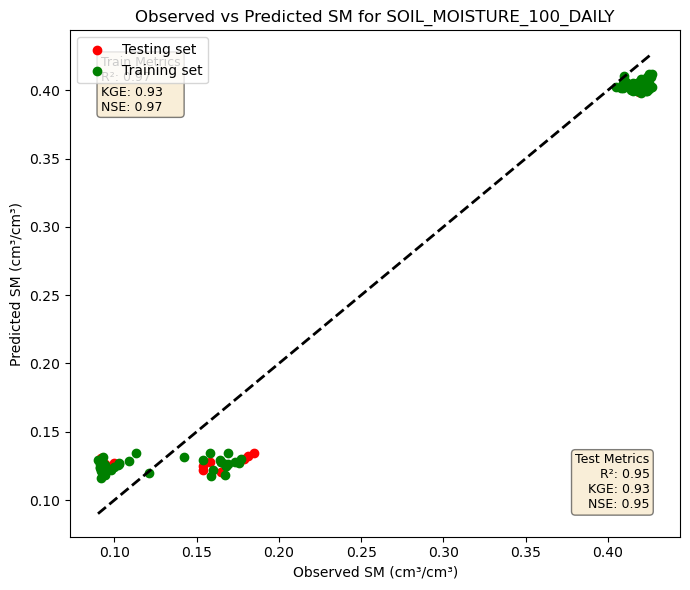

100%|██████████| 84/84 [00:03<00:00, 23.71it/s]


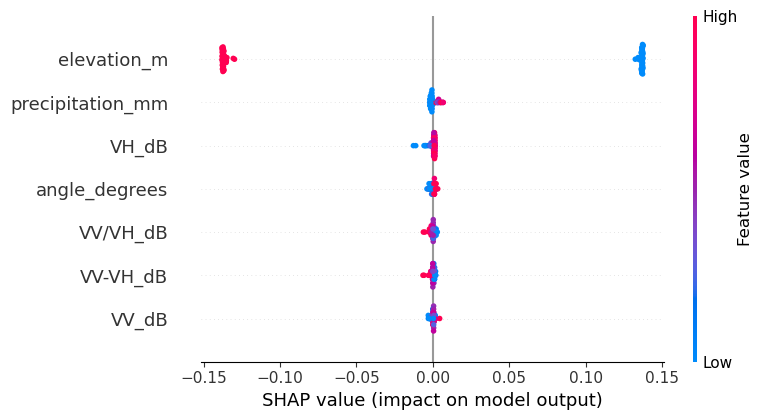

In [5]:
# ------------------------
# Define utility functions
# ------------------------

from sklearn.svm import SVR

def kge(sim, obs):
    r = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def nse(sim, obs):
    return 1 - np.sum((sim - obs)**2) / np.sum((obs - np.mean(obs))**2)

# ------------------------
# Model Training
# ------------------------

depths_cm = [5, 10, 20, 50, 100]
target_columns = [f'SOIL_MOISTURE_{d}_DAILY' for d in depths_cm]
features = ['VV_dB', 'VH_dB', 'angle_degrees', 'precipitation_mm', 'elevation_m', 'VV-VH_dB', 'VV/VH_dB']

# SVR hyperparameter space
space = {
    'C': hp.loguniform('C', np.log(0.1), np.log(100)),
    'epsilon': hp.uniform('epsilon', 0.01, 0.2),
    'gamma': hp.loguniform('gamma', np.log(0.001), np.log(1)),
}

random_seed = 42
X = df[features]

# Dictionary to store models and scalers
targets = {}

for depth, target_col in zip(depths_cm, target_columns):
    print(f"\n--- Training SVR for {target_col} ---")
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Scale inputs
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define optimization objective
    def objective(params):
        model = SVR(C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'])
        kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        rmse_list = []
        for train_idx, val_idx in kf.split(X_train_scaled):
            model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
            preds = model.predict(X_train_scaled[val_idx])
            rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], preds))
            rmse_list.append(rmse)
        return {'loss': np.mean(rmse_list), 'status': STATUS_OK}

    # Hyperparameter tuning
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50,
                trials=trials, rstate=np.random.default_rng(random_seed))

    # Final model
    final_model = SVR(C=best['C'], epsilon=best['epsilon'], gamma=best['gamma'])
    final_model.fit(X_train_scaled, y_train)

    y_pred_train = final_model.predict(X_train_scaled)
    y_pred_test = final_model.predict(X_test_scaled)

    # Print metrics
    print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}, KGE: {kge(y_pred_train, y_train):.3f}, NSE: {nse(y_pred_train, y_train):.3f}")
    print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}, KGE: {kge(y_pred_test, y_test):.3f}, NSE: {nse(y_pred_test, y_test):.3f}")

    # Observed vs Predicted Scatterplot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_test, y_pred_test, color='red', label='Testing set')
    ax.scatter(y_train, y_pred_train, color='green', label='Training set')
    ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95,
            f"Train Metrics\nR²: {r2_score(y_train, y_pred_train):.2f}\nKGE: {kge(y_pred_train, y_train):.2f}\nNSE: {nse(y_pred_train, y_train):.2f}",
            transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
    ax.text(0.95, 0.05,
            f"Test Metrics\nR²: {r2_score(y_test, y_pred_test):.2f}\nKGE: {kge(y_pred_test, y_test):.2f}\nNSE: {nse(y_pred_test, y_test):.2f}",
            transform=ax.transAxes, fontsize=9, ha='right', verticalalignment='bottom', bbox=props)

    ax.set_xlabel('Observed SM (cm³/cm³)')
    ax.set_ylabel('Predicted SM (cm³/cm³)')
    ax.set_title(f"Observed vs Predicted SM for {target_col}")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"Results/SVR_Observed_vs_Predicted_{target_col}.png", dpi=300)
    plt.show()

    # --------------------
    # Add SHAP analysis
    # --------------------
    # Use a background sample from the training set for the KernelExplainer
    import shap
    background = X_train_scaled[:100]
    explainer = shap.KernelExplainer(final_model.predict, background)
    shap_values = explainer.shap_values(X_train_scaled, nsamples=100)
    
    # Create and save the SHAP summary plot
    shap.summary_plot(shap_values, X_train_scaled, feature_names=features, show=False)
    plt.tight_layout()
    plt.savefig(f"Results/SHAP_summary_{target_col}.png", dpi=300)
    plt.show()

    # Store model and scaler
    targets[target_col] = (final_model, scaler)


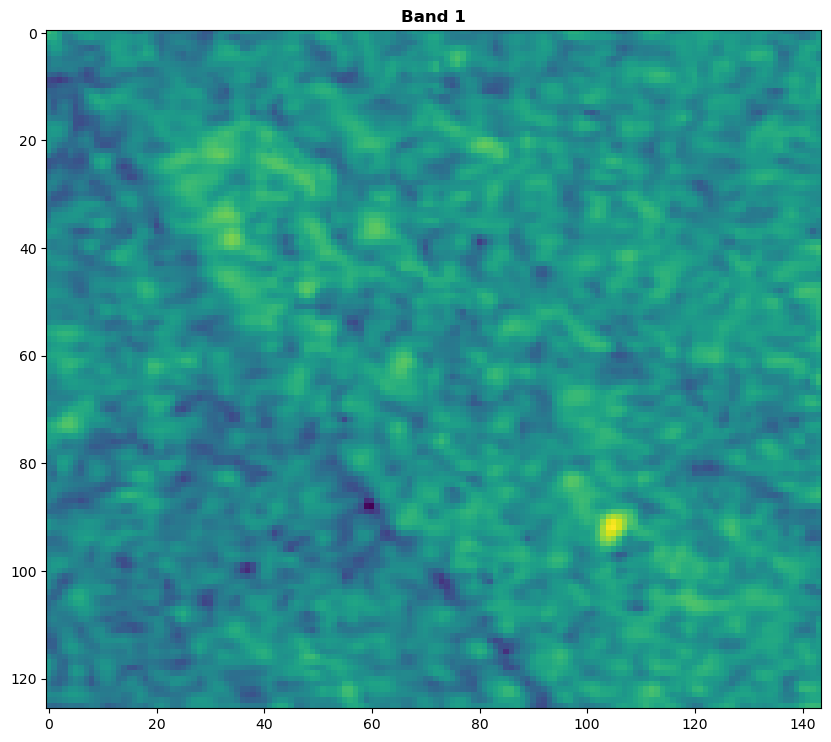

Band names: ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5']


In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the TIFF file
file_path = 'Datasets/FrankFort_Lexington_MultiBand_2024.tif'
with rasterio.open(file_path) as dataset:
    # Display the first band of the TIFF file
    plt.figure(figsize=(10, 10))
    show(dataset.read(1), title="Band 1")
    plt.show()
    
    # Print the band names
    band_names = [f"Band {i}" for i in range(1, dataset.count + 1)]
    print("Band names:", band_names)

In [7]:
import rasterio
import numpy as np
from rasterio.transform import from_origin

# Open the input TIFF file
with rasterio.open(file_path) as dataset:
    # Read all bands into a numpy array
    raster_data = dataset.read()

# Calculate VV-VH and VV/VH bands
vv_vh_band = raster_data[0] - raster_data[1]  # VV-VH
vv_div_vh_band = raster_data[0] / raster_data[1]  # VV/VH

# Stack the bands in the specified order
new_bands = [
    raster_data[0],  # VV [dB]
    raster_data[1],  # VH [dB]
    raster_data[2],  # angle [degrees]
    raster_data[3],  # precipitation [mm]
    raster_data[4],  # elevation [m]
    vv_vh_band,      # VV-VH [dB]
    vv_div_vh_band   # VV/VH [dB]
]
new_bands = np.stack(new_bands)

# Define metadata for the new TIFF
new_meta = dataset.meta.copy()
new_meta.update({
    "count": len(new_bands),  # Number of bands
    "dtype": new_bands.dtype  # Data type of the bands
})

# Write the new TIFF file
output_file = "Datasets/Updated_Frankfor_Lexington.tif"
with rasterio.open(output_file, "w", **new_meta) as dst:
    for i in range(len(new_bands)):
        dst.write(new_bands[i], i + 1)  # Write each band to the file

print(f"New TIFF file created: {output_file}")

New TIFF file created: Datasets/Updated_Frankfor_Lexington.tif


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


Saved: Results/SVR_Predicted_Soil_Moisture_5.tif
Saved: Results/SVR_Predicted_Soil_Moisture_10.tif
Saved: Results/SVR_Predicted_Soil_Moisture_20.tif
Saved: Results/SVR_Predicted_Soil_Moisture_50.tif
Saved: Results/SVR_Predicted_Soil_Moisture_100.tif


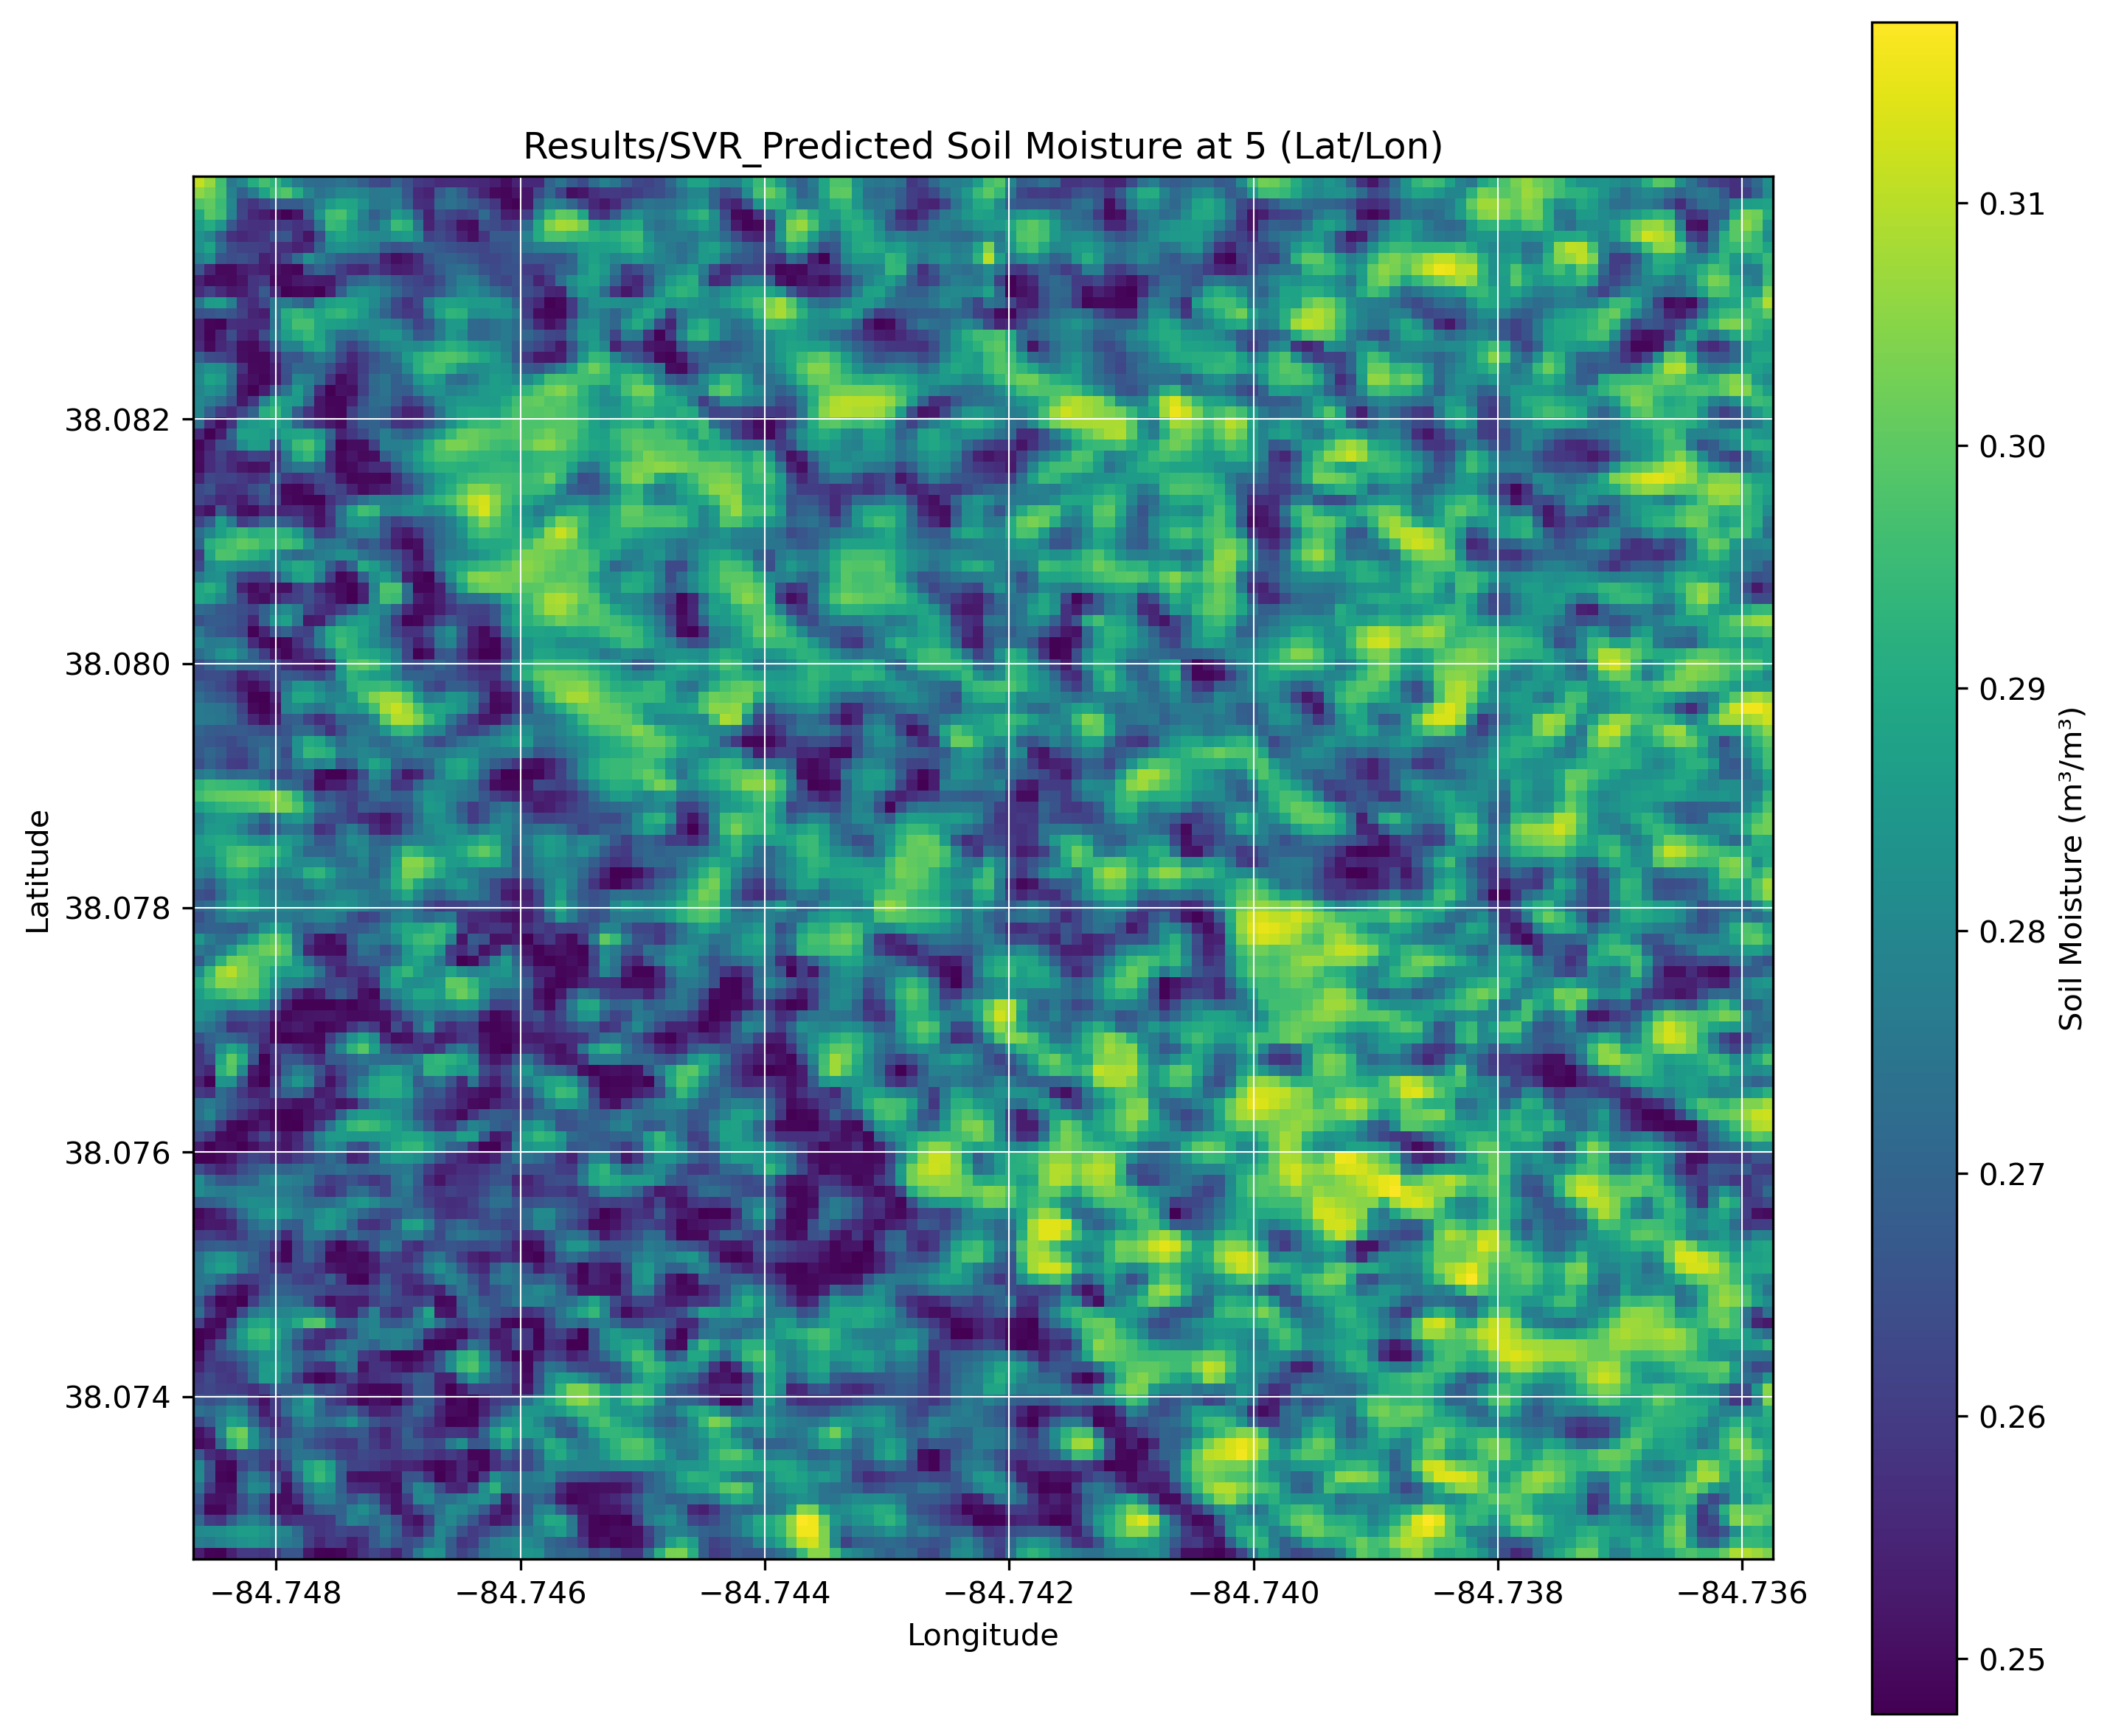

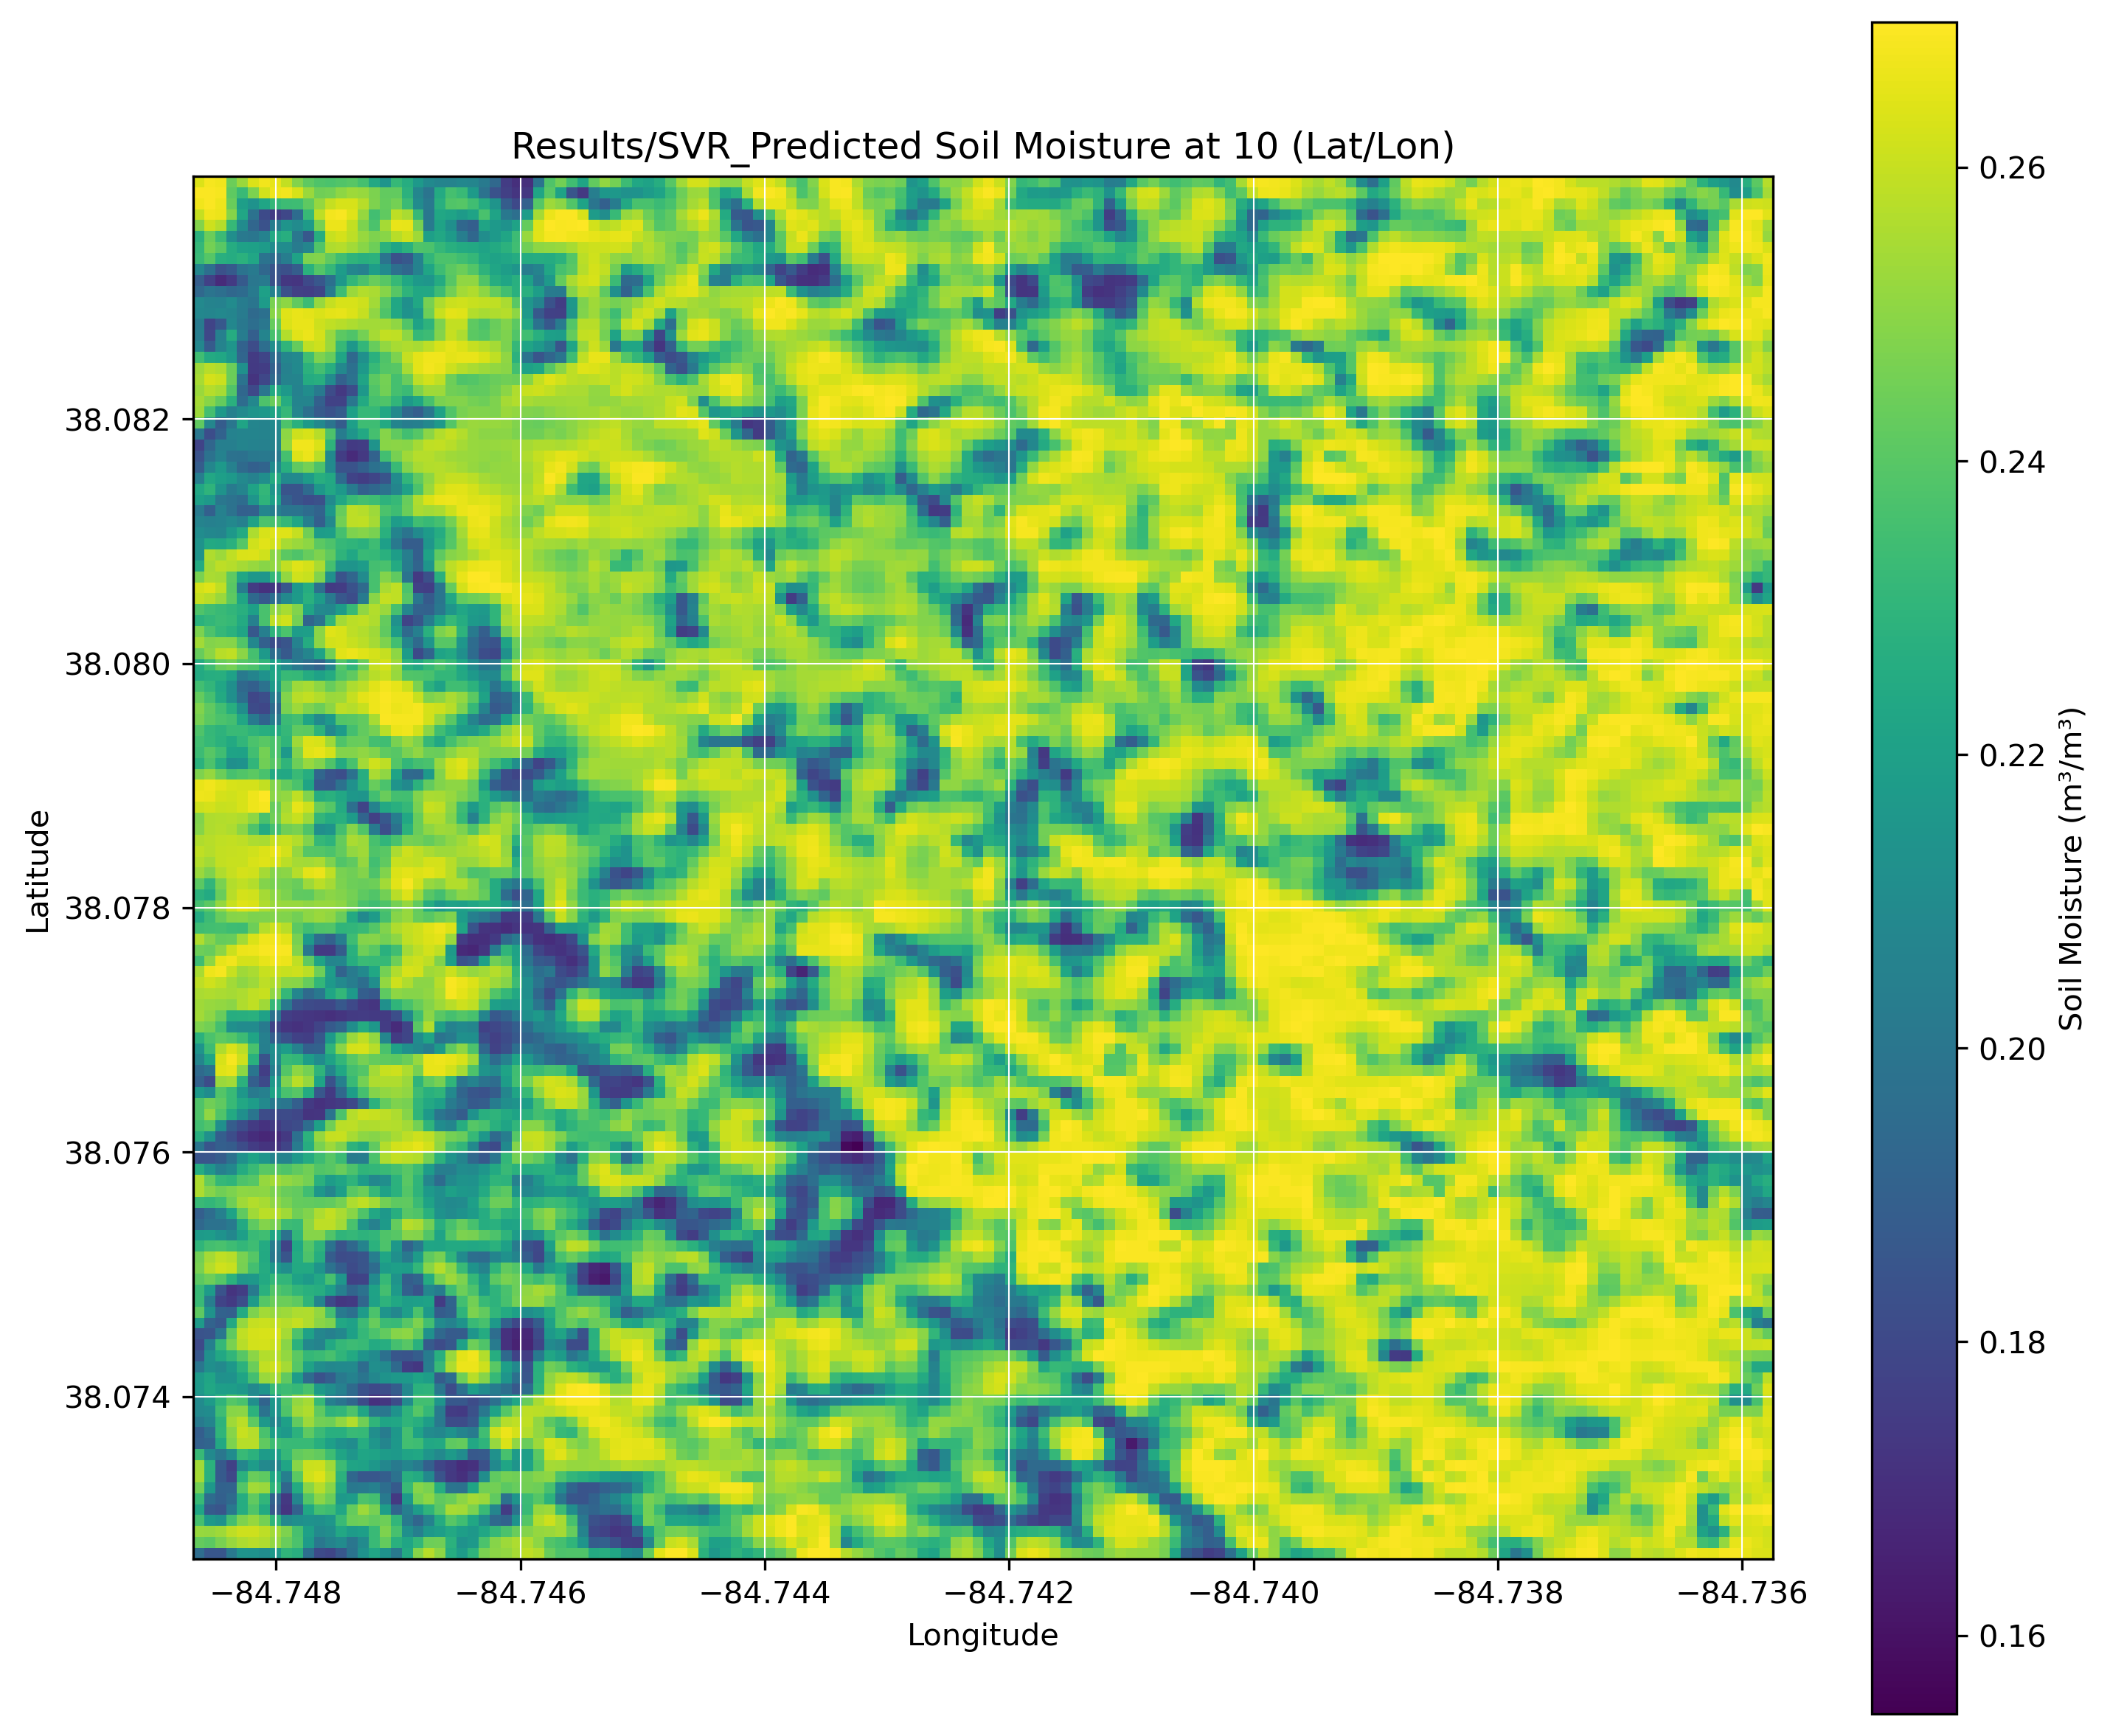

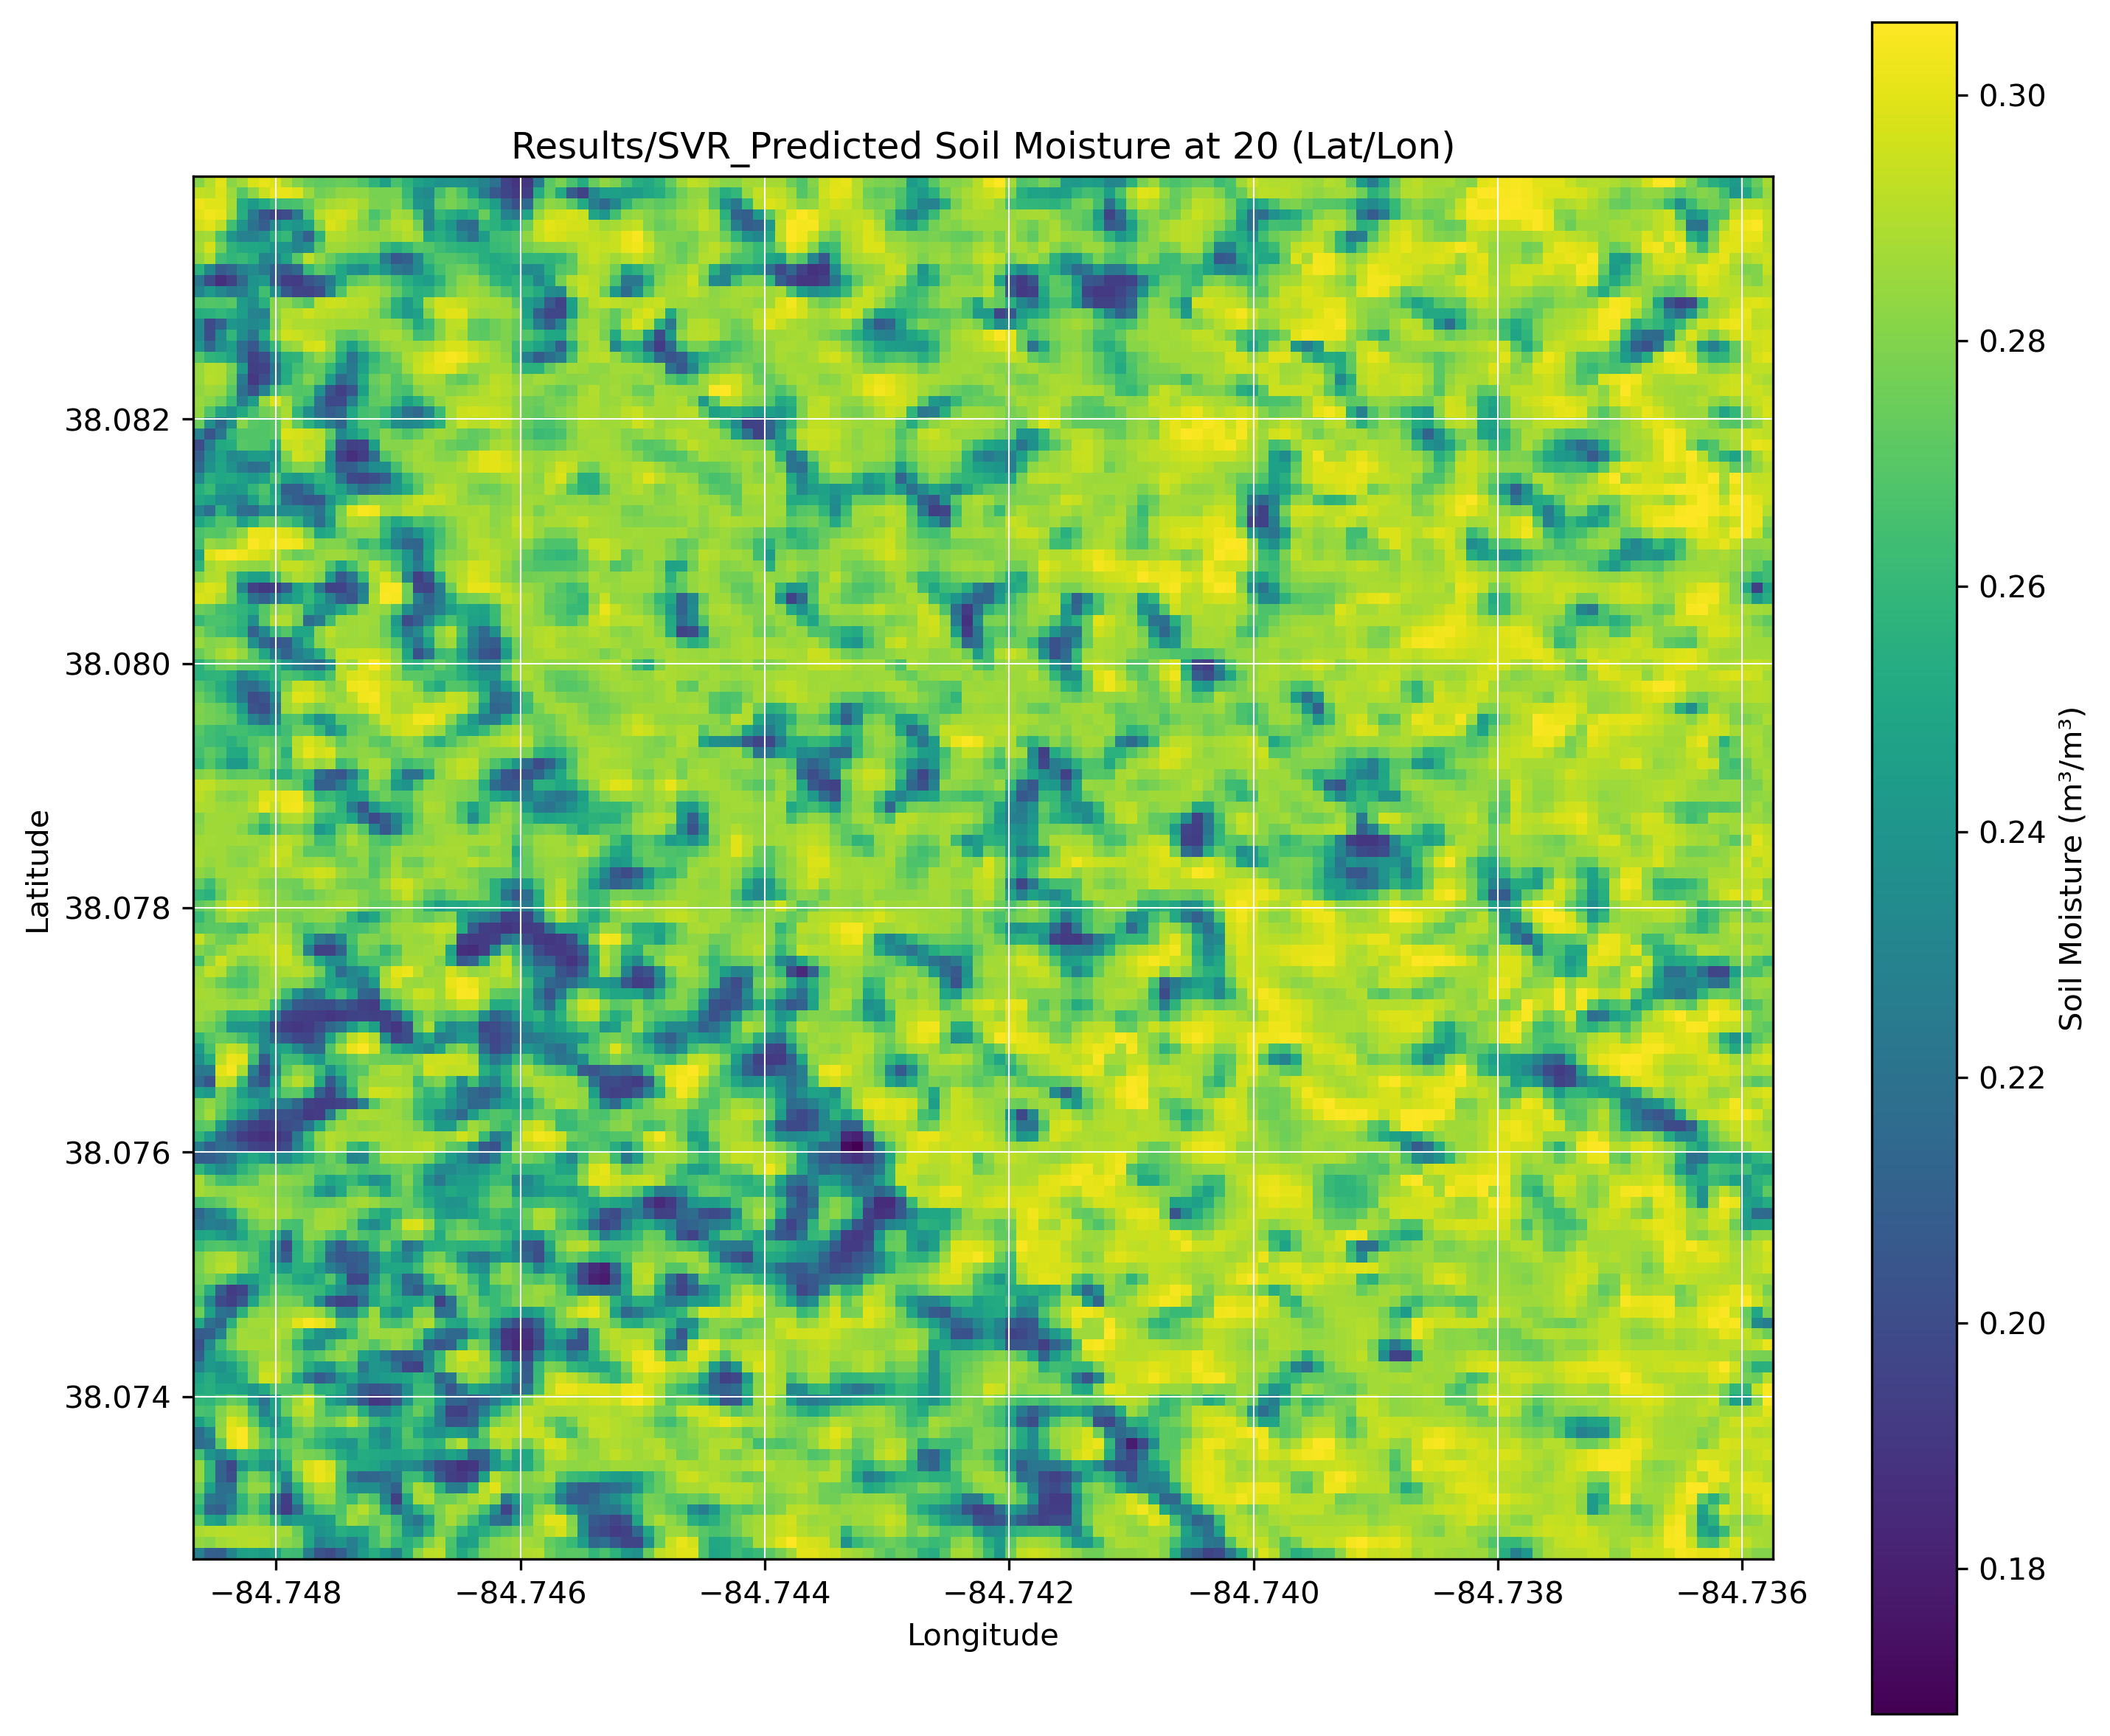

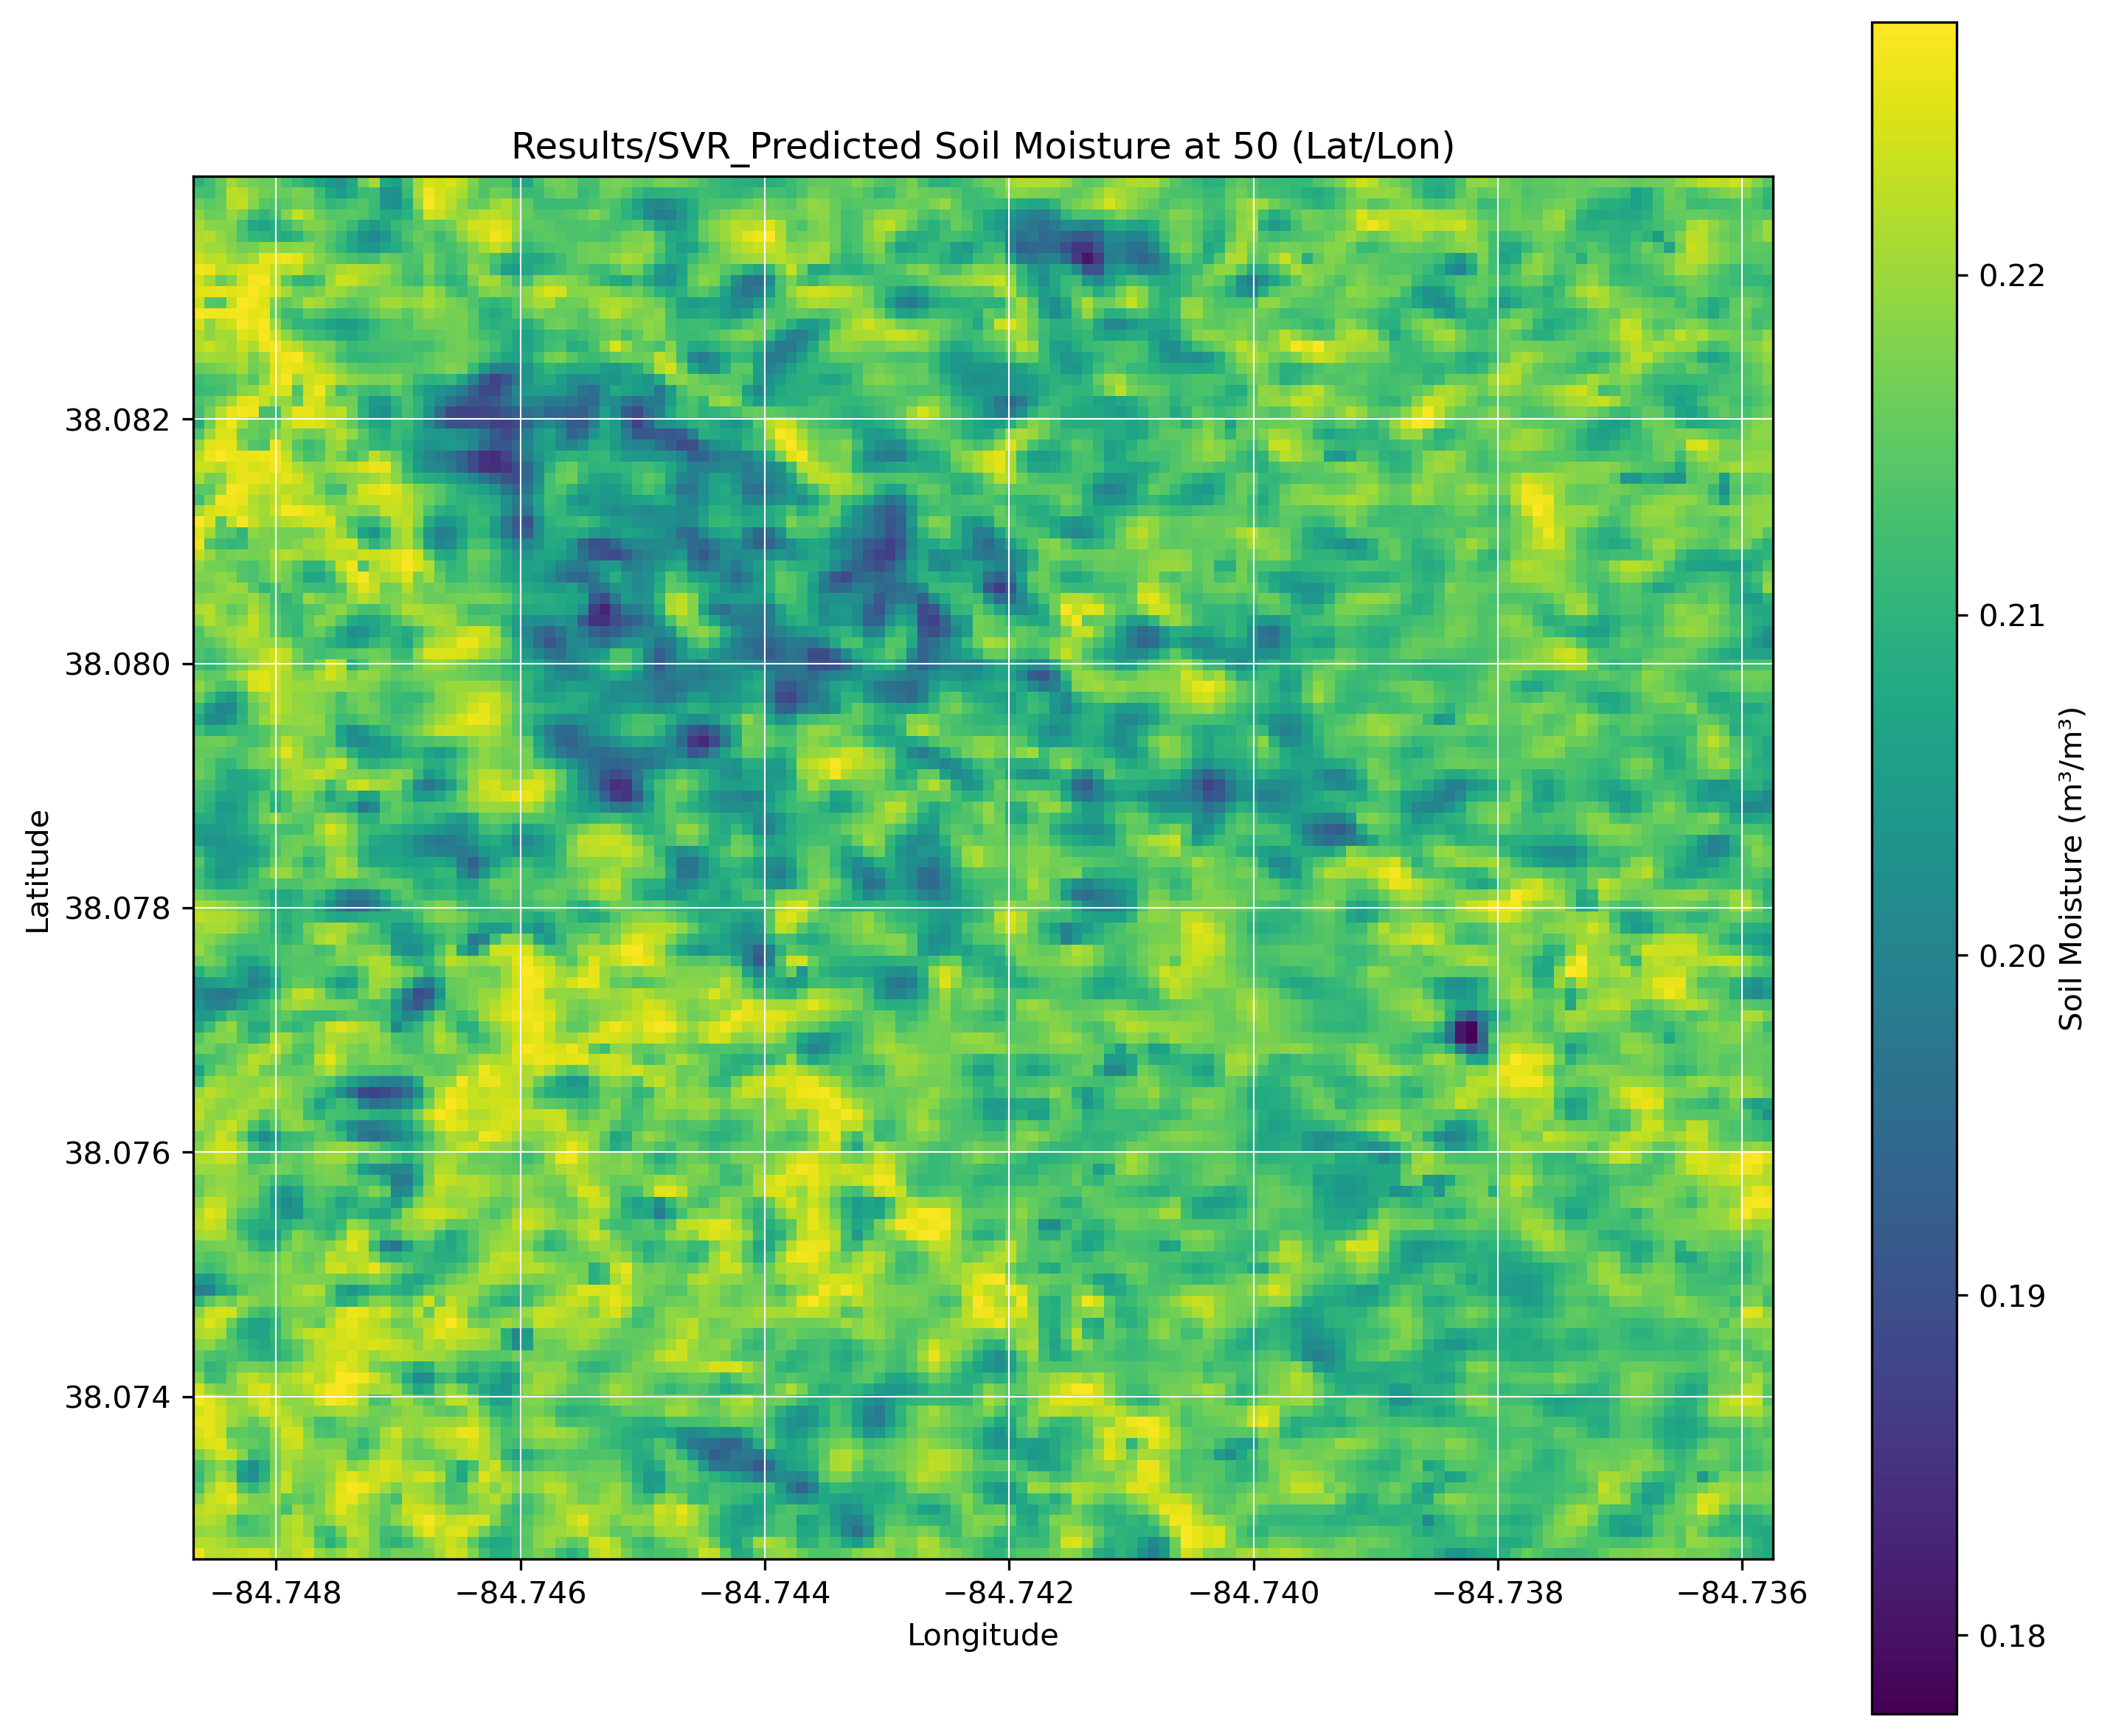

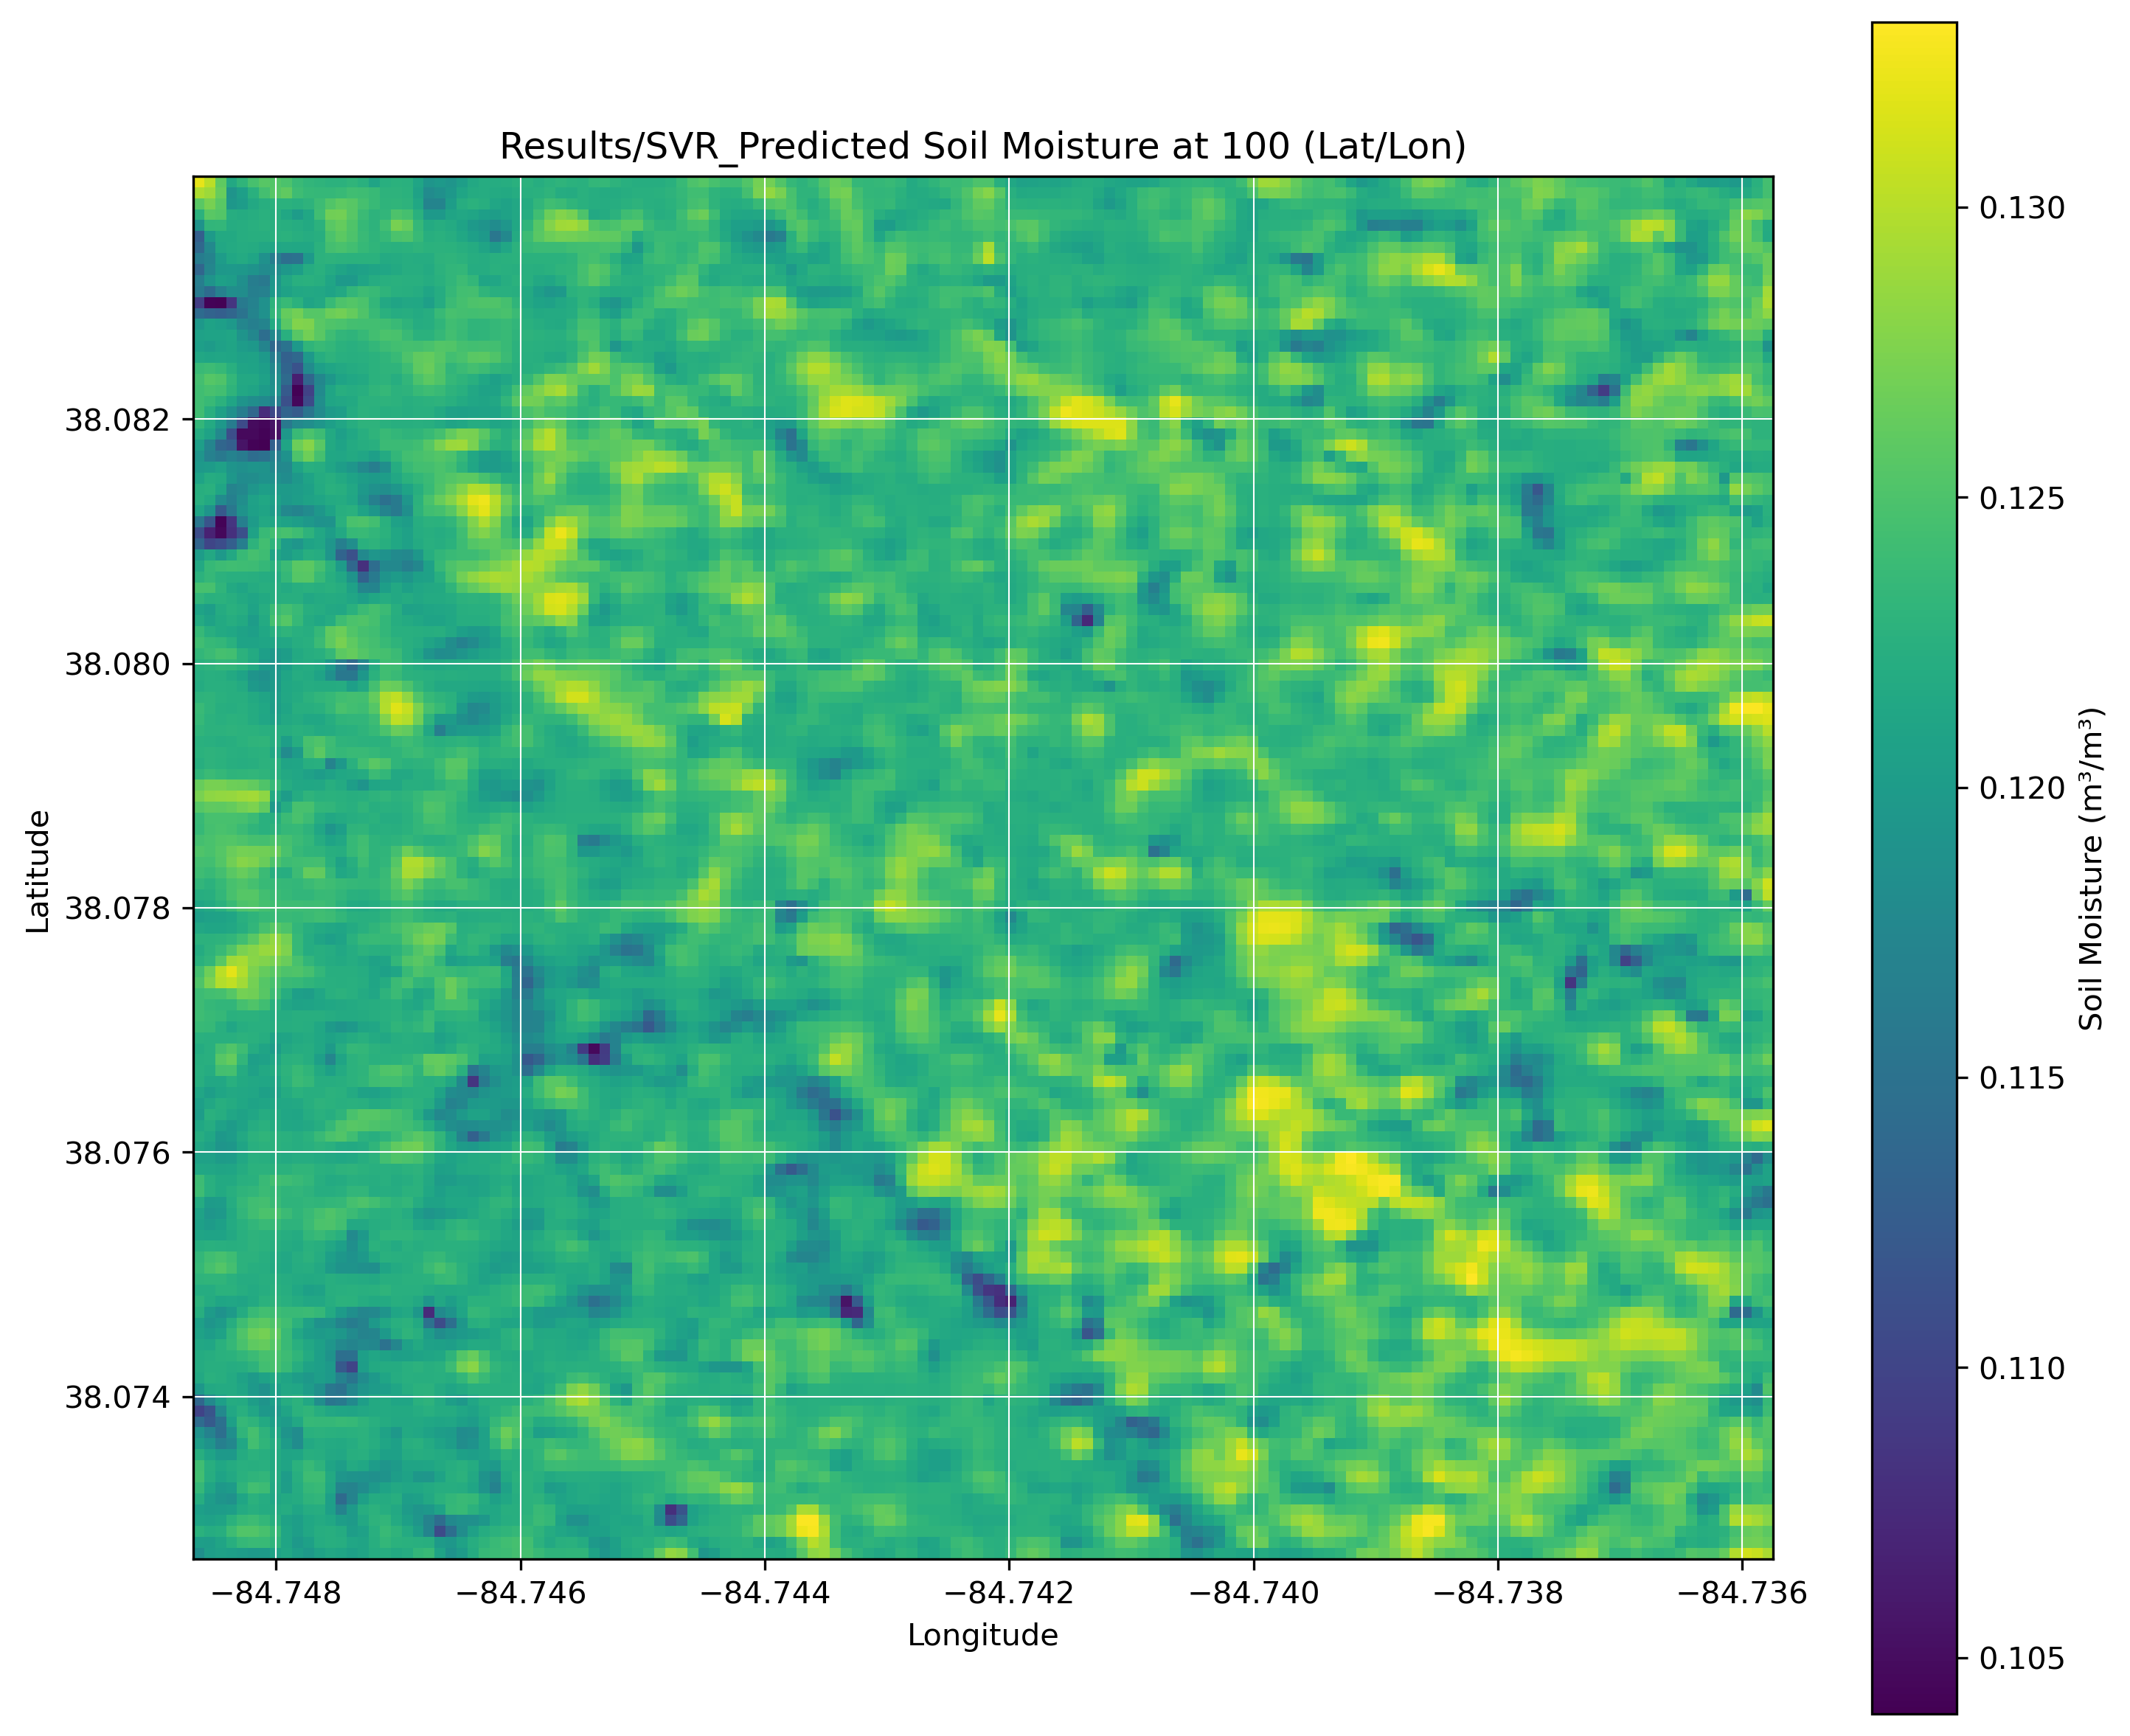

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Paths and model setup
tiff_path = "Datasets/Updated_Frankfor_Lexington.tif"
depths_cm = [5, 10, 20, 50, 100]
target_columns = [f"SOIL_MOISTURE_{d}_DAILY" for d in depths_cm]
features = ['VV_dB', 'VH_dB', 'angle_degrees', 'precipitation_mm', 'elevation_m', 'VV-VH_dB', 'VV/VH_dB']

# Training feature stats for clipping
feature_stats = {feat: (df[feat].min(), df[feat].max()) for feat in features}

# Read raster
with rasterio.open(tiff_path) as src:
    bands = src.read()  # (bands, rows, cols)
    bands = np.transpose(bands, (1, 2, 0))  # (rows, cols, bands)
    rows, cols, num_bands = bands.shape
    reshaped_data = bands.reshape(-1, num_bands)

    # DO NOT normalize elevation manually
    # DO NOT replace precipitation with mean

    # Clip all features to match training ranges
    for i, feat in enumerate(features):
        min_val, max_val = feature_stats[feat]
        reshaped_data[:, i] = np.clip(reshaped_data[:, i], min_val, max_val)

    # Predict with trained SVR models
    predicted_sm = np.zeros((reshaped_data.shape[0], len(depths_cm)))

    for i, target_col in enumerate(target_columns):
        model, scaler = targets[target_col]
        scaled_input = scaler.transform(reshaped_data)  # <--- this scales elevation too
        predicted_sm[:, i] = model.predict(scaled_input)

    predicted_sm = predicted_sm.reshape(rows, cols, len(depths_cm))
    
    # Save predicted soil moisture for each depth as GeoTIFF
    for i, depth in enumerate(depths_cm):
        output_file = f"Results/SVR_Predicted_Soil_Moisture_{depth}.tif"
        meta = src.meta.copy()
        meta.update({
            "count": 1,  # Single band
            "dtype": predicted_sm.dtype
        })
        with rasterio.open(output_file, "w", **meta) as dst:
            dst.write(predicted_sm[:, :, i], 1)  # Write the i-th depth band
        print(f"Saved: {output_file}")

    
def plot_geotiff_with_latlon(tif_path, title):
    with rasterio.open(tif_path) as src:
        image = src.read(1)
        transform = src.transform

        # Get bounds
        left, bottom, right, top = src.bounds

        # Create extent in lat/lon
        extent = (left, right, bottom, top)

        # Plot
        plt.figure(figsize=(10, 8), dpi=300)
        plt.imshow(image, cmap='viridis', extent=extent, origin='upper')
        plt.colorbar(label='Soil Moisture (m³/m³)')
        plt.title(title)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True, which='both', color='white', linewidth=0.5)  # optional grid
        plt.tight_layout()
        plt.show()

# Example: Plot one of your saved TIFFs
for depth in depths_cm:
    depth_str = f"{depth}"
    plot_geotiff_with_latlon(f"Results/SVR_Predicted_Soil_Moisture_{depth_str}.tif",
                             f"Results/SVR_Predicted Soil Moisture at {depth_str} (Lat/Lon)")


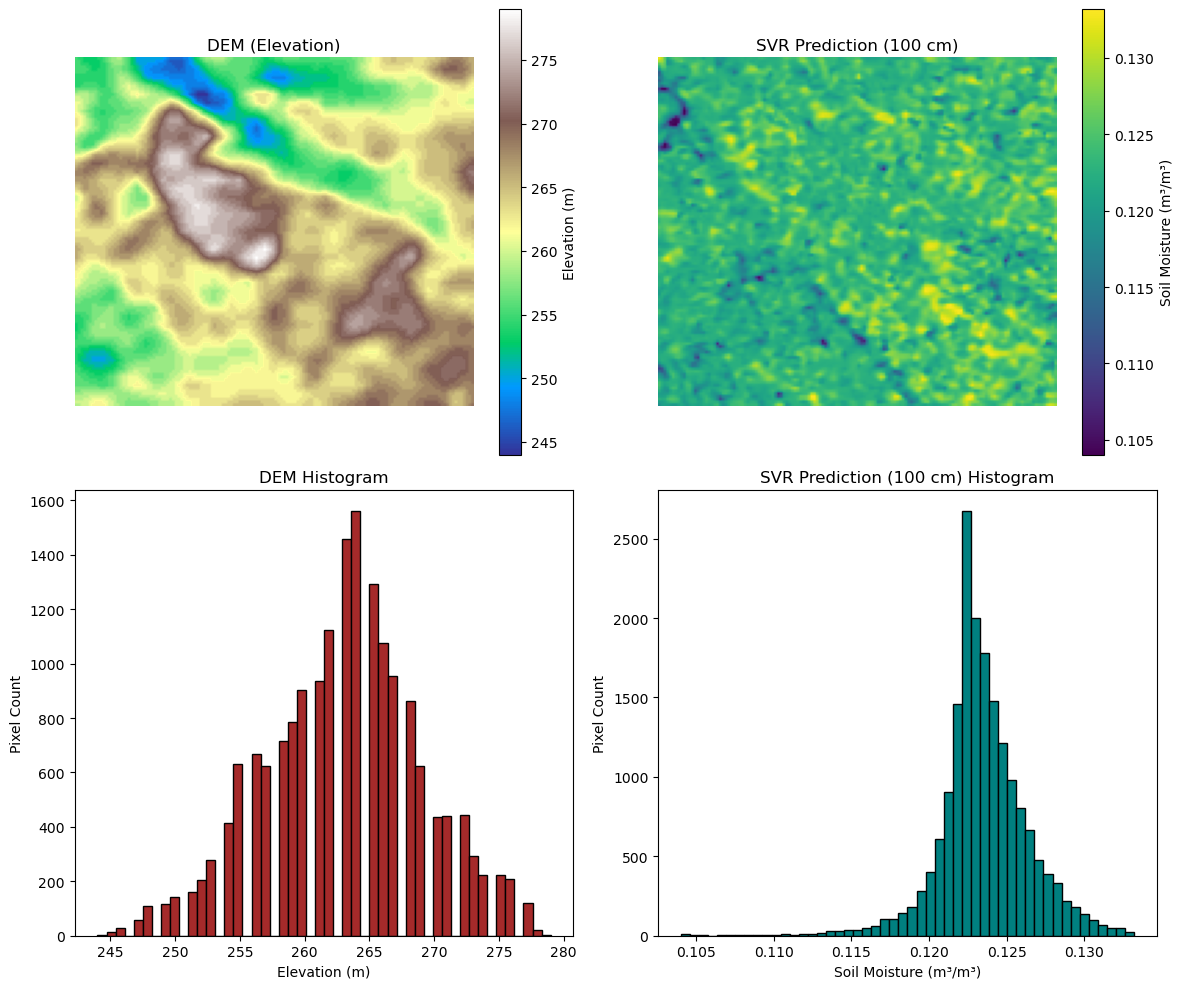

In [11]:
import rasterio

import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    dem = src.read(5)  # 5th band for DEM
    svr_100cm = predicted_sm[:, :, 4]  # 100 cm prediction from SVR

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Removed constrained_layout=True

# First row: Spatial plots
# DEM spatial plot
im1 = axes[0, 0].imshow(dem, cmap='terrain')
axes[0, 0].set_title("DEM (Elevation)")
axes[0, 0].axis('off')
fig.colorbar(im1, ax=axes[0, 0], orientation='vertical', label='Elevation (m)')

# SVR 100 cm spatial plot
im2 = axes[0, 1].imshow(svr_100cm, cmap='viridis')
axes[0, 1].set_title("SVR Prediction (100 cm)")
axes[0, 1].axis('off')
fig.colorbar(im2, ax=axes[0, 1], orientation='vertical', label='Soil Moisture (m³/m³)')

# Second row: Histograms
# DEM histogram
axes[1, 0].hist(dem.flatten(), bins=50, color='brown', edgecolor='black')
axes[1, 0].set_title("DEM Histogram")
axes[1, 0].set_xlabel("Elevation (m)")
axes[1, 0].set_ylabel("Pixel Count")

# SVR 100 cm histogram
axes[1, 1].hist(svr_100cm.flatten(), bins=50, color='teal', edgecolor='black')
axes[1, 1].set_title("SVR Prediction (100 cm) Histogram")
axes[1, 1].set_xlabel("Soil Moisture (m³/m³)")
axes[1, 1].set_ylabel("Pixel Count")

# Adjust layout
fig.tight_layout()  # Use tight_layout instead of constrained_layout
plt.show()

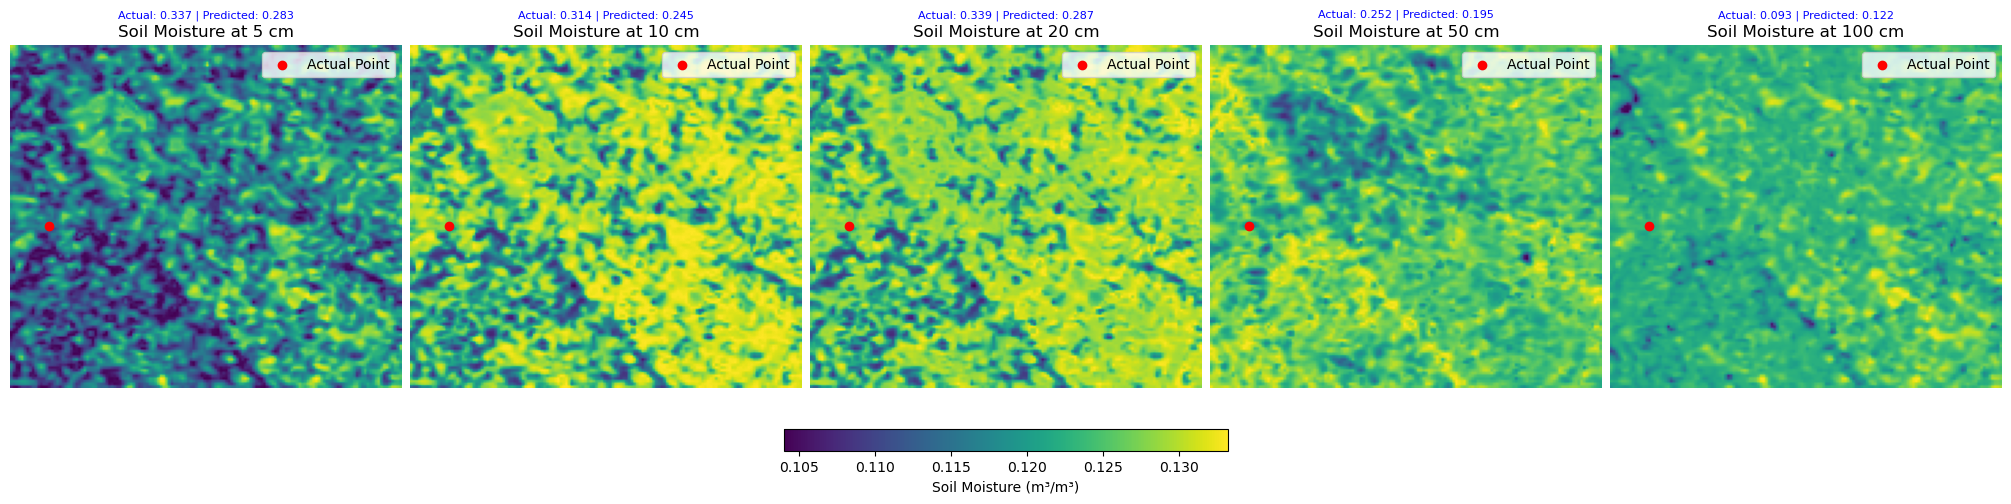

Saved RMSE comparison to insitu_comparison_rmse.csv


In [12]:
# Compare with in-situ data and log metrics
insitu_data = pd.read_csv("Datasets/cleaned_Insitu_SM_2024_ILINKS.csv")
#insitu_data['SOIL_MOISTURE_15_DAILY'] = (insitu_data['SOIL_MOISTURE_10_DAILY'] + insitu_data['SOIL_MOISTURE_20_DAILY']) / 2
#insitu_data['SOIL_MOISTURE_75_DAILY'] = (insitu_data['SOIL_MOISTURE_50_DAILY'] + insitu_data['SOIL_MOISTURE_100_DAILY']) / 2

latitude = 38.09
longitude = -84.75
date = 20240101
point = insitu_data[(insitu_data['LATITUDE'] == latitude) &
                    (insitu_data['LONGITUDE'] == longitude) &
                    (insitu_data['LST_DATE'] == date)]
actual_values = point[['SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY']].values.flatten()

lat_idx = int((latitude - src.bounds.top) / src.res[1])
lon_idx = int((src.bounds.left - longitude) / src.res[0])
predicted_values = predicted_sm[lat_idx, lon_idx, :]

# Initialize rmse_log as an empty list
rmse_log = []

fig, axes = plt.subplots(1, 5, figsize=(20, 6), constrained_layout=True)

for i, ax in enumerate(axes):
    im = ax.imshow(predicted_sm[:, :, i], cmap='viridis')
    ax.set_title(f"Soil Moisture at {depths_cm[i]} cm")
    ax.axis('off')
    ax.scatter(lon_idx, lat_idx, color='red', label='Actual Point')
    ax.legend()
    ax.text(0.5, 1.08, f"Actual: {actual_values[i]:.3f} | Predicted: {predicted_values[i]:.3f}",
            transform=ax.transAxes, fontsize=8, ha='center', color='blue')

# Add a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.046, pad=0.08)
cbar.set_label('Soil Moisture (m³/m³)')

plt.savefig("Results/SVR_InSitu_Comparison_All_Depths.png", dpi=300)
plt.show()

# Save RMSE log to CSV
rmse_df = pd.DataFrame(rmse_log)
rmse_df.to_csv("Results/insitu_comparison_rmse.csv", index=False)
print("Saved RMSE comparison to insitu_comparison_rmse.csv")

🔍 Diagnosing SVR Raster Predictions for: SOIL_MOISTURE_50_DAILY

🔧 Feature range comparison (Train vs Raster):

VV_dB          : Train (-15.886 – -6.663) | Raster (-15.886 – -6.663)
VH_dB          : Train (-33.200 – -11.509) | Raster (-33.200 – -11.509)
angle_degrees  : Train (30.444 – 43.966) | Raster (30.838 – 30.932)
precipitation_mm: Train (0.000 – 35.960) | Raster (0.000 – 0.000)
elevation_m    : Train (-1.010 – 0.991) | Raster (0.991 – 0.991)
VV-VH_dB       : Train (-2.267 – 21.460) | Raster (-2.267 – 21.460)
VV/VH_dB       : Train (0.354 – 1.197) | Raster (0.354 – 1.166)

📊 Prediction Statistics:
Min: 0.1777
Max: 0.2274
Mean: 0.2134
Std Dev: 0.0066


X does not have valid feature names, but StandardScaler was fitted with feature names


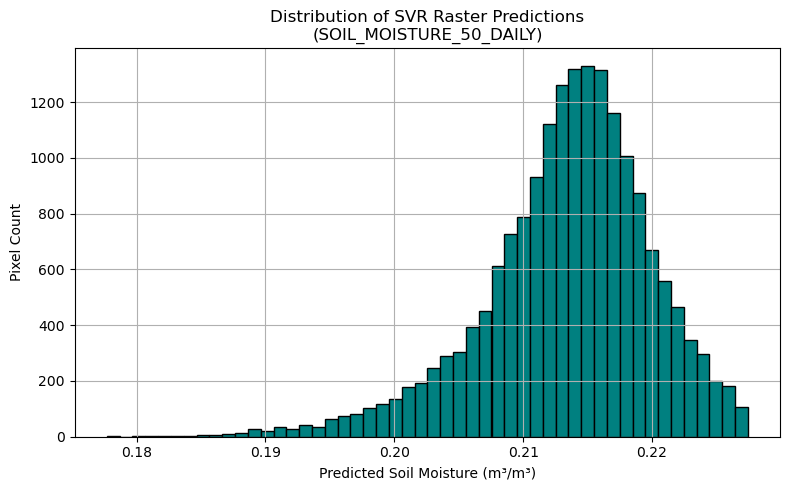

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
target_col = 'SOIL_MOISTURE_50_DAILY'  # You can change to another depth
# ----------------------------

print(f"🔍 Diagnosing SVR Raster Predictions for: {target_col}\n")

# 1. Compare raster input feature ranges with training data
print("🔧 Feature range comparison (Train vs Raster):\n")
for i, feat in enumerate(features):
    train_min, train_max = X[feat].min(), X[feat].max()
    raster_min, raster_max = reshaped_data[:, i].min(), reshaped_data[:, i].max()
    print(f"{feat:<15}: Train ({train_min:.3f} – {train_max:.3f}) | Raster ({raster_min:.3f} – {raster_max:.3f})")

# 2. Load trained SVR model and scaler
model, scaler = targets[target_col]

# 3. Scale raster input using the same StandardScaler used during training
scaled_input = scaler.transform(reshaped_data)

# 4. Predict using the SVR model
preds = model.predict(scaled_input)

# 5. Print prediction distribution stats
print("\n📊 Prediction Statistics:")
print(f"Min: {np.min(preds):.4f}")
print(f"Max: {np.max(preds):.4f}")
print(f"Mean: {np.mean(preds):.4f}")
print(f"Std Dev: {np.std(preds):.4f}")

# 6. Plot histogram of predictions
plt.figure(figsize=(8, 5))
plt.hist(preds, bins=50, color='teal', edgecolor='black')
plt.title(f"Distribution of SVR Raster Predictions\n({target_col})")
plt.xlabel("Predicted Soil Moisture (m³/m³)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()
